# House Prices: Advanced Regression Techniques

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV,LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import xgboost as xgb
import tensorflow as tf

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
s = train.shape[0]
y_train = np.log1p(train["SalePrice"])

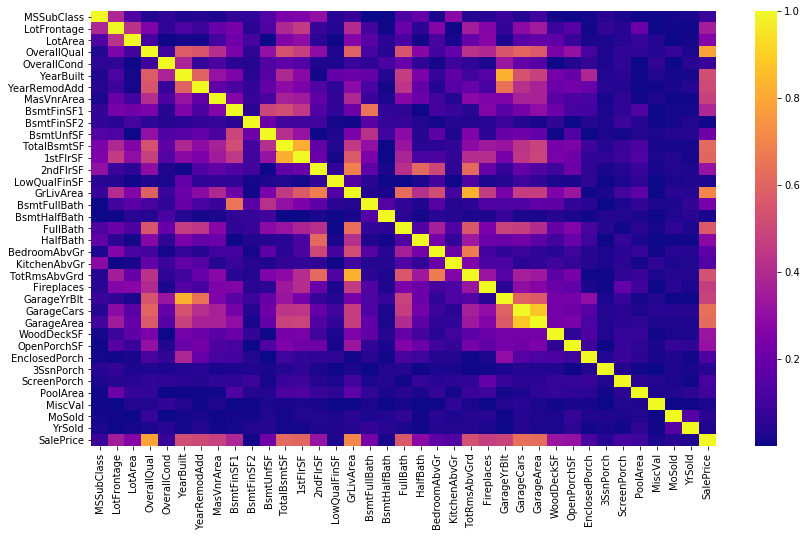

In [3]:
#heatmap plot
plt.figure(figsize=(14,8))
sns.heatmap(abs(train.corr()), cmap='plasma')

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


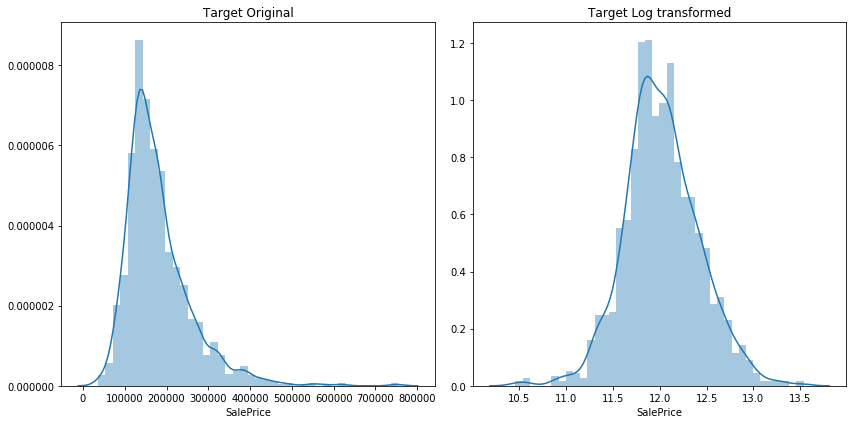

In [4]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.distplot(train.SalePrice, bins=40)
plt.title('Target Original')

plt.subplot(1,2,2)
sns.distplot(y_train, bins=40)
plt.title('Target Log transformed')

plt.tight_layout()



In [5]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.index = np.arange(1, len(all_data) + 1)

In [6]:
all_data.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
6,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
7,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
8,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
9,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
10,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


## Missing_Values

In [7]:
percent = (all_data.isnull().sum()/len(all_data)).sort_values(ascending=False)
percent.head(10)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageFinish    0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageCond      0.054471
dtype: float64

In [8]:
#categorical data: replacing NA with none
columns_1 = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'MasVnrType','MSSubClass','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
#numerical data: replacing NA with 0
columns_2 = ['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
#categorical data: replacing NA with most frequent value
columns_3 = ['MSZoning','Electrical','Utilities','KitchenQual','Functional','Exterior1st','Exterior2nd','SaleType']

for col in columns_1:
    all_data[col] = all_data[col].fillna('None')
    
for col in columns_2:
    all_data[col] = all_data[col].fillna(0)
    
for col in columns_3:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
#fill NA value with the median   
all_data["LotFrontage"] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

In [9]:
# all_data.drop('Condition2',1,inplace=True)
# all_data.drop('Utilities',1,inplace=True)

In [10]:
missing_values = []
for c in all_data.columns:
    missing_values.append(all_data[c].isnull().sum())
    if missing_values[-1] > 0:
        print(c,missing_values[-1])
if sum(missing_values) == 0:
    print('No Missing Values')

No Missing Values


In [11]:
categorical_columns = [col for col in all_data.columns.values if all_data[col].dtype == 'object']
numerical_columns = [col for col in all_data.columns.values if all_data[col].dtype != 'object']

data_num = all_data[numerical_columns]

## Skewed data: using transformations

In [12]:
data_skewed = all_data[numerical_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
data_skewed = data_skewed[abs(data_skewed) > .75]

In [13]:
data_skewed

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.674852
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
GarageYrBlt      -3.906205
dtype: float64

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

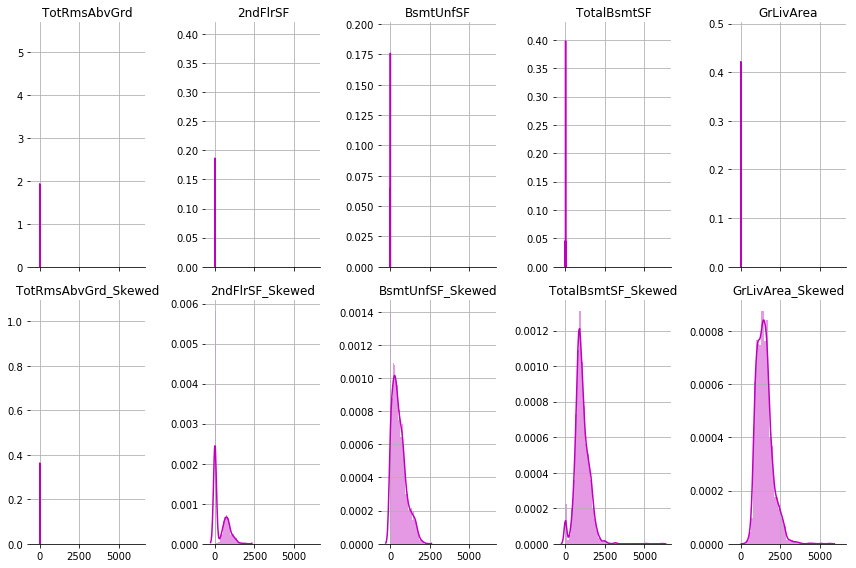

In [14]:
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,8), sharex=True)
sns.despine(left=True)
# Generate a random univariate dataset
for i in range(2):
    for j in range(5):
        ind = - (2+j)
        title = data_skewed.index[ind] 
        if i == 1:
            title = title + '_Skewed'
            sns.distplot(all_data[data_skewed.index[ind]], color="m", ax=axes[i, j],axlabel='')
        else:
            sns.distplot(boxcox1p(all_data[data_skewed.index[ind]],0.15), color="m", ax=axes[i, j],axlabel='')
        axes[i,j].set_title(title)  
        axes[i,j].grid(True)       
plt.tight_layout()

In [15]:
col = list(data_skewed.index)
# data_skewed_1 = data_skewed[data_skewed > .75]
# data_skewed_2 = data_skewed[data_skewed < -0.75]
# col_1 = list(data_skewed_1.index)
# col_2 = list(data_skewed_2.index)
# all_data[col_1] = np.log1p(all_data[col_1])    #for positively skewed
# all_data[col_2] = np.square(all_data[col_2])   #for negatively skewed
all_data[col] = boxcox1p(all_data[col], 0.15)

## Drop outliers

In [16]:
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)
IQR = Q3 - Q1


a = data_num[(data_num < (Q1 - 1.5 * IQR)) |(data_num > (Q3 + 1.5* IQR))]
b = a[a.count()[a.count() < 20].index].sum(1)
outliers = b[b>0].index
outliers = [x for x in outliers if x < s ]
#all_data.drop(outliers,inplace = True)
#y_train.drop(outliers,inplace = True)
#s -= len(outliers)
#c = ['EnclosedPorch','ScreenPorch','WoodDeckSF']

* after careful implementing of outliers removal I decide not to remove them since the final performance becoming worse

In [17]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
       'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
       'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
       'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
       'YrSold', 'MoSold')
for col in columns:
    label = LabelEncoder() 
    label.fit(list(all_data[col].values)) 
    all_data[col] = label.transform(list(all_data[col].values))

## Some data engineering

In [18]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]

In [19]:
all_data.shape

(2919, 82)

## Dummies creation

In [20]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 225)

## Train and Test data split

In [21]:
train = all_data[:s]
test = all_data[s:]

## Most important features selection using LASSO

Lasso picked 101 variables and eliminated the other 124 variables


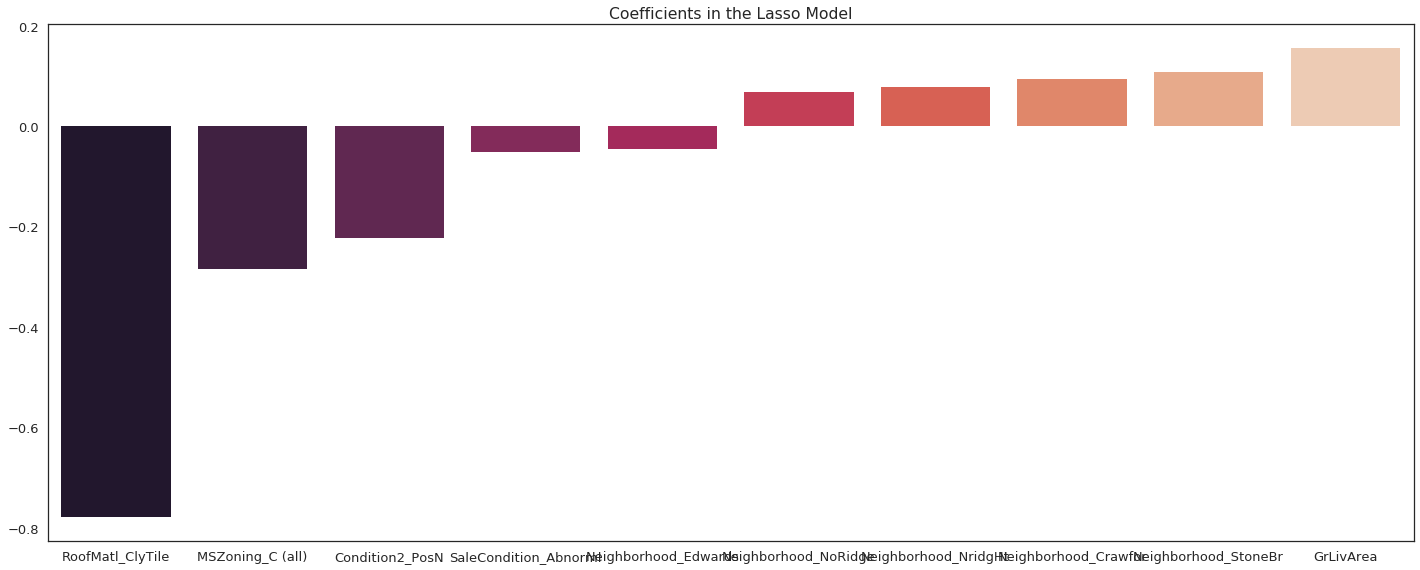

In [22]:
model_lasso = LassoCV(alphas = [5,2,1, 0.1,0.005, 0.001,0.0005]).fit(train, y_train)
coef = pd.Series(model_lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


coef = pd.concat([coef.sort_values().head(5),coef.sort_values().tail(5)])

plt.figure(figsize=(20,8))
sns.set(style="white", context="talk")
sns.barplot(coef.index,coef.values,palette="rocket")
plt.tight_layout()
plt.title("Coefficients in the Lasso Model")  
plt.show()  

In [23]:
top = np.array(abs(model_lasso.coef_)).argsort()[::-1][:101]
top = np.sort(top)
train = train.iloc[:,top]
test = test.iloc[:,top]

### 5-folds cross validation

In [24]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge Model

In [25]:
model_ridge = Ridge()
alphas = [0.01,0.003,0.05, 0.1, 0.3, 0.5, 1, 1.5, 2, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = np.array([rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas])
print("The min value of Ridge is ",cv_ridge.min())
best_alpha = alphas[cv_ridge.argmin()]
model_ridge = Ridge(alpha = best_alpha).fit(train, y_train)

The min value of Ridge is  0.1204343393094103


### LASSO Model

In [26]:
model_lasso = LassoCV(alphas = [5,2,1, 0.1,0.005, 0.001,0.0005]).fit(train, y_train)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())

The min value of Lasso is  0.12261214660994864


### Extreme Gradient Boosting Model

In [27]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.03,  
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=3, n_estimators=3000, 
                             reg_alpha=0.2, reg_lambda=0.7,
                             subsample=0.5, silent=1,
                             random_state=4, nthread = -1).fit(train, y_train)  

print("The min value of XGB is ",rmse_cv(model_xgb).mean())

The min value of XGB is  0.11905123097056905


### Gradient Boosting Model

In [28]:
model_GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber',random_state=7).fit(train,y_train)  

print("The min value of GBoost is ",rmse_cv(model_GBoost).mean())

The min value of GBoost is  0.12310575712915636


### Light Gradient Boosting Model

In [29]:
model_LGB = lgb.LGBMRegressor(objective='regression',
                              num_leaves=30, max_depth=4, learning_rate=0.01, 
                              n_estimators=2500, max_bin=250, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 12).fit(train,y_train)

print("The min value of LGB is ",rmse_cv(model_LGB).mean())

The min value of LGB is  0.12123059035110458


In [30]:
#Models Predictions
lasso_preds = np.expm1(model_lasso.predict(test))
ridge_preds = np.expm1(model_ridge.predict(test))
xgb_preds = np.expm1(model_xgb.predict(test))
GBoost_preds = np.expm1(model_GBoost.predict(test))
LGB_preds = np.expm1(model_LGB.predict(test))

### Tensorflow Shallow Multilayer Perceptron

In [31]:
#Data Normalization between [0,1]
all_data = all_data.iloc[:,top]
scaler = MinMaxScaler()
scaler.fit(all_data)

train = pd.DataFrame(scaler.transform(train),columns = train.columns)
test  = pd.DataFrame(scaler.transform(test),columns = test.columns)

train['SalePrice'] = y_train

train.head()

,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,RoofMatl_ClyTile,RoofMatl_WdShngl,RoofStyle_Gable,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleType_COD,SaleType_New,SaleType_WD,SalePrice
0,0.818185,0.0,0.5,0.375,1.00,0.75,0.631368,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.247699
1,0.000000,0.0,0.5,0.375,1.00,0.25,0.681814,0.0,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.109016
2,0.820875,0.0,0.5,0.375,1.00,0.50,0.576542,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.317171
3,0.794934,0.0,0.5,0.375,0.25,0.75,0.467677,0.0,0.000000,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,11.849405
4,0.859155,0.0,0.5,0.500,1.00,0.00,0.620109,0.0,0.333333,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.429220


In [32]:
train.rename({'Exterior1st_Wd Sdng':'Exterior1st_Wd_Sdng'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Brk Cmn':'Exterior2nd_Brk_Cmn'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Wd Sdng':'Exterior2nd_Wd_Sdng'}, axis='columns',inplace=True)
train.rename({'Exterior2nd_Wd Shng':'Exterior2nd_Wd_Shng'}, axis='columns',inplace=True)
train.rename({'MSZoning_C (all)':'MSZoning_C_all'}, axis='columns',inplace=True)
train.rename({'HouseStyle_1.5Fin':'HouseStyle_1_5Fin'}, axis='columns',inplace=True)
train.rename({'HouseStyle_1.5Unf':'HouseStyle_1_5Unf'}, axis='columns',inplace=True)
train.rename({'HouseStyle_2.5Fin':'HouseStyle_2_5Fin'}, axis='columns',inplace=True)
train.rename({'HouseStyle_2.5Unf':'HouseStyle_2_5Unf'}, axis='columns',inplace=True)
train.rename({'RoofMatl_Tar&Grv':'RoofMatl_Tar_Grv'}, axis='columns',inplace=True)

In [33]:
columns = list(train.columns).copy()
features = columns[:-1]

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in features]

training_set = train[columns]
prediction_set = train.SalePrice

# Split Train and Test samples from the training_data
x_train, x_test, y_train, y_test = train_test_split(training_set[features] , prediction_set, test_size=0.3, random_state=101)
y_train = pd.DataFrame(y_train, columns = ["SalePrice"])
training_set = pd.DataFrame(x_train, columns = features).merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test, columns = ["SalePrice"])
testing_set = pd.DataFrame(x_test, columns = features).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,RoofMatl_ClyTile,RoofMatl_WdShngl,RoofStyle_Gable,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleType_COD,SaleType_New,SaleType_WD,SalePrice
1054,0.827894,0.0,0.5,0.375,1.0,0.50,0.674199,0.000000,0.333333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.449023
361,0.725139,0.0,1.0,0.375,1.0,0.75,0.548811,0.000000,0.833333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.884496
1282,0.000000,0.0,0.5,0.375,1.0,0.50,0.589537,0.553942,0.500000,0.833333,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.921725
161,0.867132,0.0,0.5,0.375,1.0,0.00,0.687878,0.000000,0.333333,1.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.929994
515,0.000000,0.0,0.5,0.375,1.0,0.75,0.744544,0.000000,0.333333,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.906349


In [34]:
# Model decision
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200,80,20],
                                         optimizer = tf.train.ProximalAdagradOptimizer(learning_rate=0.05,l1_regularization_strength=0.0005),
                                         dropout=False)

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f593083de10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_mode

In [35]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [36]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in features}
        labels = tf.constant(data_set['SalePrice'].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in features}
        
        return feature_cols

In [37]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=30000)

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpohnzhi_h/model.ckpt.
INFO:tensorflow:loss = 148.4411, step = 1
INFO:tensorflow:global_step/sec: 73.8811
INFO:tensorflow:loss = 0.38989794, step = 101 (1.355 sec)
INFO:tensorflow:global_step/sec: 78.0212
INFO:tensorflow:loss = 0.24830794, step = 201 (1.281 sec)
INFO:tensorflow:global_step/sec: 76.9652
INFO:tensorflow:loss = 0.17285965, step = 301 (1.299 sec)
INFO:tensorflow:global_step/sec: 72.8502
INFO:tensorflow:loss = 0.13572197, step = 401 (1.373 sec)
INFO:tensorflow:global_step/sec: 74.3189
INFO:tensorflow:loss = 0.1098902, step = 501 (1.347 s

INFO:tensorflow:global_step/sec: 76.3914
INFO:tensorflow:loss = 0.032068048, step = 2701 (1.311 sec)
INFO:tensorflow:global_step/sec: 81.5745
INFO:tensorflow:loss = 0.03165215, step = 2801 (1.229 sec)
INFO:tensorflow:global_step/sec: 76.2096
INFO:tensorflow:loss = 0.030408124, step = 2901 (1.307 sec)
INFO:tensorflow:global_step/sec: 77.8779
INFO:tensorflow:loss = 0.030514112, step = 3001 (1.284 sec)
INFO:tensorflow:global_step/sec: 78.6455
INFO:tensorflow:loss = 0.030096257, step = 3101 (1.274 sec)
INFO:tensorflow:global_step/sec: 76.4729
INFO:tensorflow:loss = 0.029167391, step = 3201 (1.317 sec)
INFO:tensorflow:global_step/sec: 80.3535
INFO:tensorflow:loss = 0.028794935, step = 3301 (1.233 sec)
INFO:tensorflow:global_step/sec: 77.8879
INFO:tensorflow:loss = 0.028148154, step = 3401 (1.284 sec)
INFO:tensorflow:global_step/sec: 84.5446
INFO:tensorflow:loss = 0.027866937, step = 3501 (1.183 sec)
INFO:tensorflow:global_step/sec: 75.9259
INFO:tensorflow:loss = 0.02739114, step = 3601 (1.3

INFO:tensorflow:loss = 0.013636912, step = 10801 (1.355 sec)
INFO:tensorflow:global_step/sec: 67.4393
INFO:tensorflow:loss = 0.013709966, step = 10901 (1.477 sec)
INFO:tensorflow:global_step/sec: 72.2171
INFO:tensorflow:loss = 0.013485298, step = 11001 (1.385 sec)
INFO:tensorflow:global_step/sec: 72.2624
INFO:tensorflow:loss = 0.013376767, step = 11101 (1.384 sec)
INFO:tensorflow:global_step/sec: 78.4129
INFO:tensorflow:loss = 0.013451106, step = 11201 (1.281 sec)
INFO:tensorflow:global_step/sec: 77.4652
INFO:tensorflow:loss = 0.013254943, step = 11301 (1.285 sec)
INFO:tensorflow:global_step/sec: 75.5669
INFO:tensorflow:loss = 0.0131852105, step = 11401 (1.325 sec)
INFO:tensorflow:global_step/sec: 71.7946
INFO:tensorflow:loss = 0.01319992, step = 11501 (1.392 sec)
INFO:tensorflow:global_step/sec: 67.3145
INFO:tensorflow:loss = 0.013012644, step = 11601 (1.485 sec)
INFO:tensorflow:global_step/sec: 77.5652
INFO:tensorflow:loss = 0.012990806, step = 11701 (1.289 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 73.723
INFO:tensorflow:loss = 0.009245147, step = 18901 (1.354 sec)
INFO:tensorflow:global_step/sec: 76.9258
INFO:tensorflow:loss = 0.009344844, step = 19001 (1.299 sec)
INFO:tensorflow:global_step/sec: 75.2331
INFO:tensorflow:loss = 0.009682704, step = 19101 (1.326 sec)
INFO:tensorflow:global_step/sec: 77.3492
INFO:tensorflow:loss = 0.00981446, step = 19201 (1.292 sec)
INFO:tensorflow:global_step/sec: 74.1378
INFO:tensorflow:loss = 0.009742963, step = 19301 (1.349 sec)
INFO:tensorflow:global_step/sec: 78.5419
INFO:tensorflow:loss = 0.00964215, step = 19401 (1.272 sec)
INFO:tensorflow:global_step/sec: 79.6134
INFO:tensorflow:loss = 0.009016228, step = 19501 (1.257 sec)
INFO:tensorflow:global_step/sec: 78.9549
INFO:tensorflow:loss = 0.0095663145, step = 19601 (1.279 sec)
INFO:tensorflow:global_step/sec: 79.5736
INFO:tensorflow:loss = 0.009848952, step = 19701 (1.244 sec)
INFO:tensorflow:global_step/sec: 71.1005
INFO:tensorflow:loss = 0.009110052, step = 

INFO:tensorflow:global_step/sec: 72.3233
INFO:tensorflow:loss = 0.007891755, step = 27001 (1.370 sec)
INFO:tensorflow:global_step/sec: 78.7567
INFO:tensorflow:loss = 0.008154235, step = 27101 (1.267 sec)
INFO:tensorflow:global_step/sec: 80.1043
INFO:tensorflow:loss = 0.008504138, step = 27201 (1.251 sec)
INFO:tensorflow:global_step/sec: 78.035
INFO:tensorflow:loss = 0.008261066, step = 27301 (1.278 sec)
INFO:tensorflow:global_step/sec: 77.42
INFO:tensorflow:loss = 0.007859021, step = 27401 (1.291 sec)
INFO:tensorflow:global_step/sec: 82.0652
INFO:tensorflow:loss = 0.008370462, step = 27501 (1.219 sec)
INFO:tensorflow:global_step/sec: 79.3944
INFO:tensorflow:loss = 0.00842558, step = 27601 (1.260 sec)
INFO:tensorflow:global_step/sec: 77.44
INFO:tensorflow:loss = 0.008089881, step = 27701 (1.292 sec)
INFO:tensorflow:global_step/sec: 76.5254
INFO:tensorflow:loss = 0.008003346, step = 27801 (1.305 sec)
INFO:tensorflow:global_step/sec: 78.3853
INFO:tensorflow:loss = 0.008044437, step = 2790

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f5930815198>, 'hidden_units': [200, 80, 20], 'feature_columns': (_RealValuedColumn(column_name='2ndFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Alley', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BedroomAbvGr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtExposure', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFi

In [38]:
# Model Evaluation
evaluate = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
print("Final Loss on the testing set: {0:f}".format(evaluate["loss"]))

INFO:tensorflow:Starting evaluation at 2019-01-17-08:49:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpohnzhi_h/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-17-08:49:08
INFO:tensorflow:Saving dict for global step 30000: global_step = 30000, loss = 0.030543206
Final Loss on the testing set: 0.030543


In [39]:
y1 = regressor.predict(input_fn=lambda: input_fn(training_set))
predictions_train = list(itertools.islice(y1, training_set.shape[0]))
target1 = y_train['SalePrice'].values

y2 = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions_test = list(itertools.islice(y2, testing_set.shape[0]))
target2 = y_test['SalePrice'].values

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpohnzhi_h/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpohnzhi_h/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


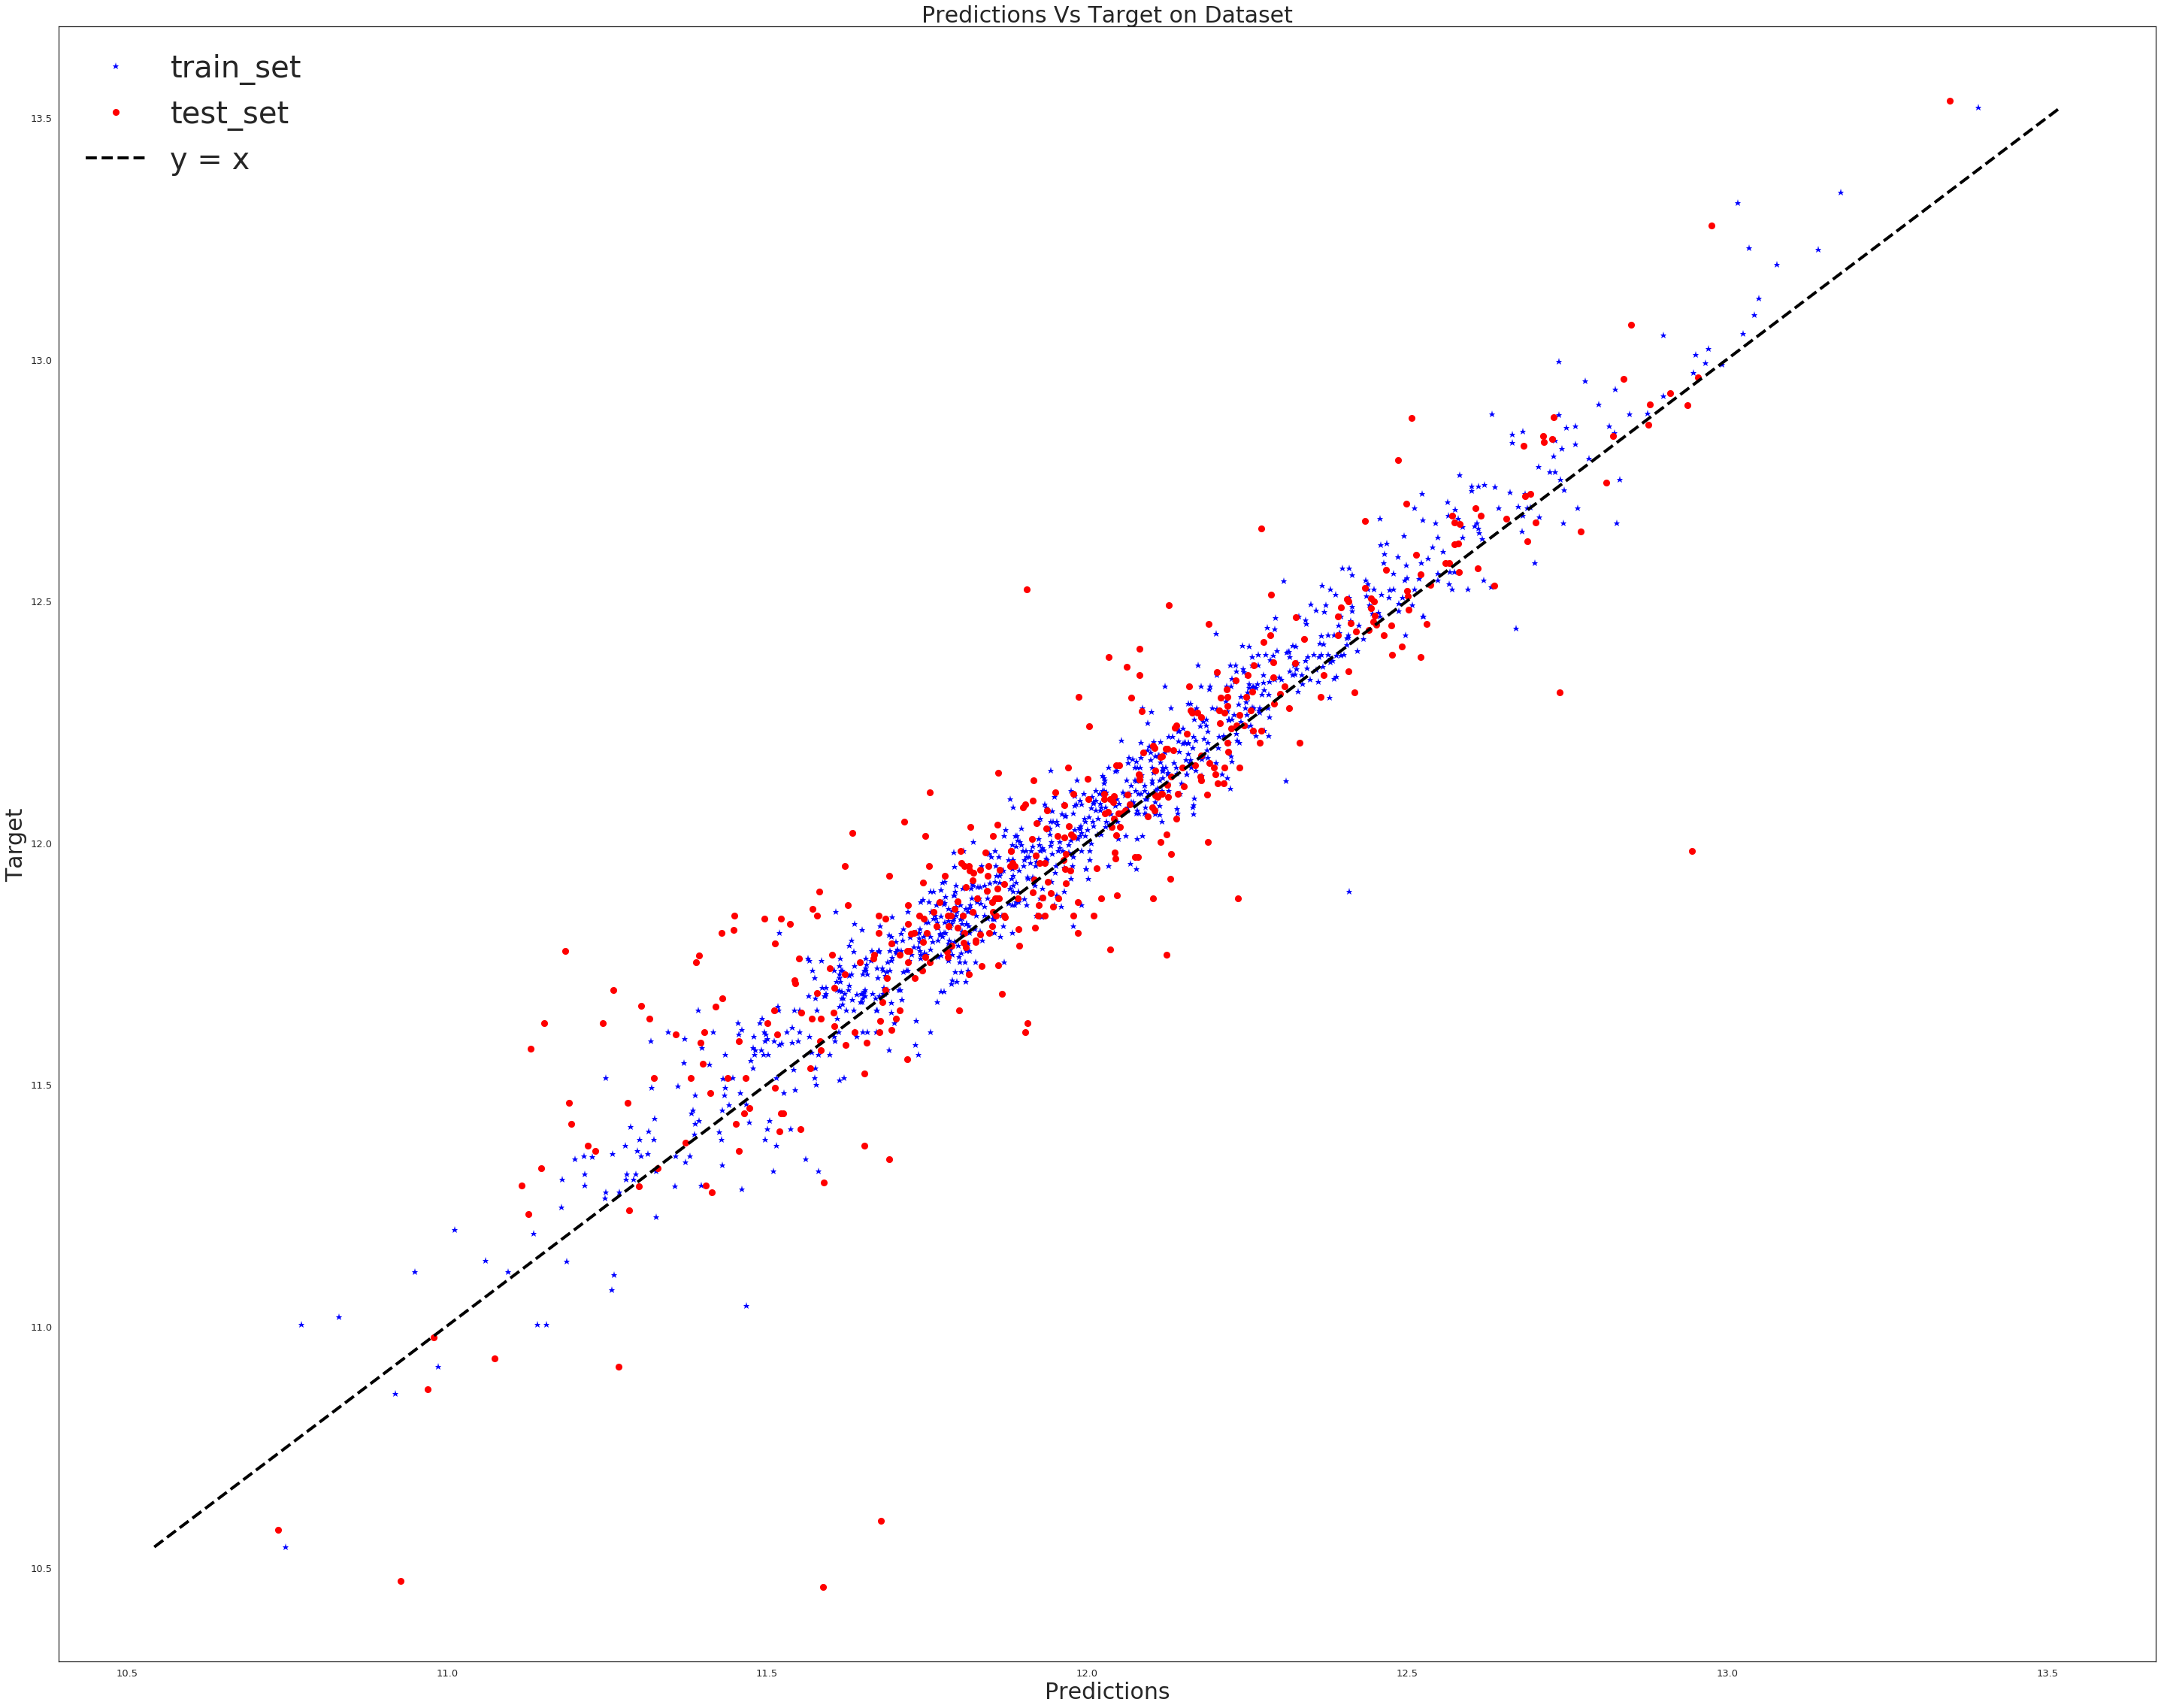

In [40]:
plt.figure(figsize=(50, 40))

plt.plot(predictions_train, target1, 'b*',label='train_set')
plt.plot(predictions_test, target2, 'ro',label='test_set')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Target', fontsize = 30)
plt.title('Predictions Vs Target on Dataset', fontsize = 30)
plt.plot([target1.min(), target1.max()], [target1.min(), target1.max()], 'k--', lw=4,label='y = x')
plt.legend(prop={'size': 40})
plt.show()

In [41]:
# Final Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200,80,20],
                                         optimizer = tf.train.ProximalAdagradOptimizer(learning_rate=0.05,l1_regularization_strength=0.0005),
                                         dropout=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f58f1314710>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmp9fto_o4b'}


In [42]:
regressor.fit(input_fn=lambda: input_fn(train), steps=30000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9fto_o4b/model.ckpt.
INFO:tensorflow:loss = 150.12343, step = 1
INFO:tensorflow:global_step/sec: 49.6191
INFO:tensorflow:loss = 0.40829822, step = 101 (2.020 sec)
INFO:tensorflow:global_step/sec: 45.9935
INFO:tensorflow:loss = 0.22681677, step = 201 (2.174 sec)
INFO:tensorflow:global_step/sec: 54.968
INFO:tensorflow:loss = 0.1647883, step = 301 (1.818 sec)
INFO:tensorflow:global_step/sec: 64.163
INFO:tensorflow:loss = 0.13229656, step = 401 (1.557 sec)
INFO:tensorflow:global_step/sec: 54.7359
INFO:tensorflow:loss = 0.11468726, step = 501 (1.833 sec)
INFO:tensorflow:global_step/sec: 53.8108
INFO:tensorflow:loss = 0.10187818, step = 601 (1.854 sec)
INFO:tensorflow:global_step/sec: 55.4316
INFO:tensorflow:loss = 0.0923288, step = 701 (1.816 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.034816377, step = 3701 (1.716 sec)
INFO:tensorflow:global_step/sec: 61.3125
INFO:tensorflow:loss = 0.033836413, step = 3801 (1.629 sec)
INFO:tensorflow:global_step/sec: 58.3818
INFO:tensorflow:loss = 0.03361424, step = 3901 (1.713 sec)
INFO:tensorflow:global_step/sec: 58.8482
INFO:tensorflow:loss = 0.032632656, step = 4001 (1.713 sec)
INFO:tensorflow:global_step/sec: 58.5245
INFO:tensorflow:loss = 0.03245485, step = 4101 (1.695 sec)
INFO:tensorflow:global_step/sec: 57.7262
INFO:tensorflow:loss = 0.03189847, step = 4201 (1.732 sec)
INFO:tensorflow:global_step/sec: 58.4524
INFO:tensorflow:loss = 0.031270776, step = 4301 (1.713 sec)
INFO:tensorflow:global_step/sec: 57.7268
INFO:tensorflow:loss = 0.03142059, step = 4401 (1.730 sec)
INFO:tensorflow:global_step/sec: 61.5405
INFO:tensorflow:loss = 0.030761559, step = 4501 (1.627 sec)
INFO:tensorflow:global_step/sec: 59.5412
INFO:tensorflow:loss = 0.030714028, step = 4601 (1.676 sec)
INFO:tensorflow:global_step/sec: 61

INFO:tensorflow:global_step/sec: 54.8733
INFO:tensorflow:loss = 0.017881, step = 11901 (1.825 sec)
INFO:tensorflow:global_step/sec: 57.1874
INFO:tensorflow:loss = 0.016516186, step = 12001 (1.749 sec)
INFO:tensorflow:global_step/sec: 56.0707
INFO:tensorflow:loss = 0.017855331, step = 12101 (1.789 sec)
INFO:tensorflow:global_step/sec: 58.9089
INFO:tensorflow:loss = 0.01680196, step = 12201 (1.692 sec)
INFO:tensorflow:global_step/sec: 59.0735
INFO:tensorflow:loss = 0.016553966, step = 12301 (1.690 sec)
INFO:tensorflow:global_step/sec: 60.6517
INFO:tensorflow:loss = 0.018017162, step = 12401 (1.649 sec)
INFO:tensorflow:global_step/sec: 59.3143
INFO:tensorflow:loss = 0.01710482, step = 12501 (1.688 sec)
INFO:tensorflow:global_step/sec: 58.7513
INFO:tensorflow:loss = 0.016653767, step = 12601 (1.713 sec)
INFO:tensorflow:global_step/sec: 59.0715
INFO:tensorflow:loss = 0.01657172, step = 12701 (1.687 sec)
INFO:tensorflow:global_step/sec: 60.756
INFO:tensorflow:loss = 0.017422305, step = 12801

INFO:tensorflow:global_step/sec: 55.8317
INFO:tensorflow:loss = 0.0136785675, step = 20001 (1.782 sec)
INFO:tensorflow:global_step/sec: 52.8321
INFO:tensorflow:loss = 0.013577637, step = 20101 (1.893 sec)
INFO:tensorflow:global_step/sec: 59.0877
INFO:tensorflow:loss = 0.01320365, step = 20201 (1.692 sec)
INFO:tensorflow:global_step/sec: 56.0731
INFO:tensorflow:loss = 0.0138618285, step = 20301 (1.795 sec)
INFO:tensorflow:global_step/sec: 58.7934
INFO:tensorflow:loss = 0.013842223, step = 20401 (1.693 sec)
INFO:tensorflow:global_step/sec: 54.8316
INFO:tensorflow:loss = 0.0132626835, step = 20501 (1.836 sec)
INFO:tensorflow:global_step/sec: 59.9248
INFO:tensorflow:loss = 0.013901542, step = 20601 (1.656 sec)
INFO:tensorflow:global_step/sec: 58.752
INFO:tensorflow:loss = 0.0129515035, step = 20701 (1.711 sec)
INFO:tensorflow:global_step/sec: 55.2956
INFO:tensorflow:loss = 0.013659194, step = 20801 (1.803 sec)
INFO:tensorflow:global_step/sec: 51.2782
INFO:tensorflow:loss = 0.012890511, ste

INFO:tensorflow:global_step/sec: 56.2182
INFO:tensorflow:loss = 0.011633371, step = 28101 (1.779 sec)
INFO:tensorflow:global_step/sec: 63.5156
INFO:tensorflow:loss = 0.011945964, step = 28201 (1.578 sec)
INFO:tensorflow:global_step/sec: 55.6893
INFO:tensorflow:loss = 0.011480779, step = 28301 (1.800 sec)
INFO:tensorflow:global_step/sec: 52.2184
INFO:tensorflow:loss = 0.011864762, step = 28401 (1.908 sec)
INFO:tensorflow:global_step/sec: 56.9523
INFO:tensorflow:loss = 0.0111402, step = 28501 (1.758 sec)
INFO:tensorflow:global_step/sec: 54.8314
INFO:tensorflow:loss = 0.011625912, step = 28601 (1.833 sec)
INFO:tensorflow:global_step/sec: 61.8727
INFO:tensorflow:loss = 0.01162386, step = 28701 (1.605 sec)
INFO:tensorflow:global_step/sec: 51.7402
INFO:tensorflow:loss = 0.011386369, step = 28801 (1.935 sec)
INFO:tensorflow:global_step/sec: 52.0687
INFO:tensorflow:loss = 0.0112994835, step = 28901 (1.922 sec)
INFO:tensorflow:global_step/sec: 56.9239
INFO:tensorflow:loss = 0.011402304, step = 

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f58f13144e0>, 'hidden_units': [200, 80, 20], 'feature_columns': (_RealValuedColumn(column_name='2ndFlrSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Alley', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BedroomAbvGr', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtExposure', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFinSF1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='BsmtFi

In [43]:
test.rename({'Exterior1st_Wd Sdng':'Exterior1st_Wd_Sdng'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Brk Cmn':'Exterior2nd_Brk_Cmn'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Wd Sdng':'Exterior2nd_Wd_Sdng'}, axis='columns',inplace=True)
test.rename({'Exterior2nd_Wd Shng':'Exterior2nd_Wd_Shng'}, axis='columns',inplace=True)
test.rename({'MSZoning_C (all)':'MSZoning_C_all'}, axis='columns',inplace=True)
test.rename({'HouseStyle_1.5Fin':'HouseStyle_1_5Fin'}, axis='columns',inplace=True)
test.rename({'HouseStyle_1.5Unf':'HouseStyle_1_5Unf'}, axis='columns',inplace=True)
test.rename({'HouseStyle_2.5Fin':'HouseStyle_2_5Fin'}, axis='columns',inplace=True)
test.rename({'HouseStyle_2.5Unf':'HouseStyle_2_5Unf'}, axis='columns',inplace=True)
test.rename({'RoofMatl_Tar&Grv':'RoofMatl_Tar_Grv'}, axis='columns',inplace=True)

In [44]:
# Tensorflow Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
tf_preds = np.expm1(list(itertools.islice(y_predict, test.shape[0])))
tf_preds[0:10]

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9fto_o4b/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([128144.97, 176641.38, 190837.28, 202569.16, 211783.95, 173805.97,
       190183.56, 167476.22, 192296.25, 112800.37], dtype=float32)

## Weighted Average Model

In [45]:
preds = 0.15*lasso_preds  + 0.15*ridge_preds + 0.2*xgb_preds + 0.2*GBoost_preds +0.15*LGB_preds  + 0.15*tf_preds

In [46]:
preds[0:10]

array([122359.65590587, 160702.2958757 , 184352.19106929, 194463.029574  ,
       196978.86660223, 173292.5301317 , 177536.58752464, 165511.3803422 ,
       184001.22506254, 122559.30953874])

In [50]:
ID = list(range(1461,1461+len(preds)))

results = pd.DataFrame()
results['Id'] = ID
results.Id = results.Id.astype(int)
results['SalePrice'] = preds

results.to_csv('output.csv',index=False)    #--> 0.11482